<a href="https://colab.research.google.com/github/Gittu-Thampi/water_body_mapping/blob/main/Waterbody_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <strong>GPU</strong>

To know the gpu used


In [ ]:
!nvidia-smi


In [ ]:
from functools import partial
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm
from pylab import *


In [ ]:
images_dir = "/content/drive/MyDrive/programs/GlacialMaping/Datasets/Images"
masks_dir = "/content/drive/MyDrive/programs/GlacialMaping/Datasets/Masks"

#images_dir = "/content/drive/MyDrive/programs/GlacialMaping/WaterBodies/Images"
#masks_dir = "/content/drive/MyDrive/programs/GlacialMaping/WaterBodies/Masks"


dirname, _, filenames = next(os.walk(images_dir))


In [ ]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks', images_extension: str = 'jpg',
                       masks_extension: str = 'jpg') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    return (image, mask)

In [ ]:
tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

In [ ]:
@tf.function
def scale_values(images, masks, mask_split_threshold=128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

In [ ]:
@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

In [ ]:
#batch_size = 10
#test_set_size = 5
#validation_set_size = 12

batch_size = 32
test_set_size = 300
validation_set_size = 250

dataset = tf.data.Dataset.list_files(images_dir + '/*.jpg', seed=42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)

In [ ]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
                          activation=hidden_activation,
                          kernel_initializer=initializer,
                          padding='same')

    # Encoder
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)

    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)

    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)

    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)

    # Decoder
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)

    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)

    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 = PartialConv(32, 3)(dec_conv_3)

    output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)

    return tf.keras.Model(inputs=model_input, outputs=output)




In [ ]:

model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)




In [ ]:

model.summary()




In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_reduce])



In [ ]:

def OtsuFilter(prediction, bias=0):
    threshold = threshold_otsu(prediction) - bias
    
    return prediction > threshold

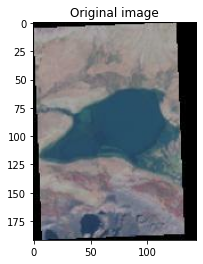

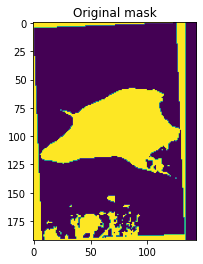

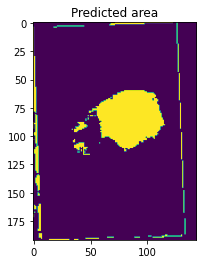

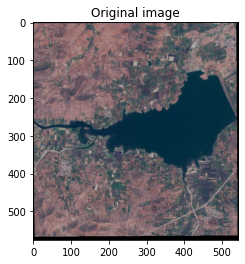

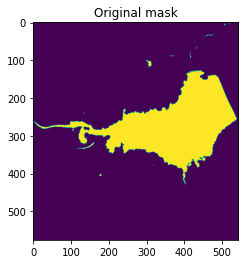

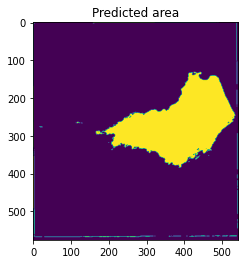

In [ ]:
n_examples = 2

#fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples * 7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
#for ele in zip(test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)


    imshow(image[0])
    plt.title('Original image')
    plt.show()
    imshow(np.squeeze(mask[0]))
    plt.title('Original mask')
    plt.show()
    imshow(np.squeeze(prediction))
    plt.title('Predicted area')
    plt.show()





In [ ]:
#!tensorboard --logdir=logs/ --host localhost --port 8088 

In [ ]:
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples * 7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)

    print(image.shape)
    print(y_true.shape)
    print(prediction.shape)

    
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)

In [ ]:
%matplotlib inline
n_examples = 3
examples = [test_dataset.take(n_examples) for i in range(n_examples)]
fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
#for ax, (image, mask) in zip(axs, examples):
for ax, ele in zip(axs, test_dataset.take(n_examples)):

    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)

    ax[0].imshow(image[0])
    ax[1].imshow(mask)
    ax[2].imshow(prediction)

In [ ]:
meanIoU = MeanIoU(num_classes=2)
for (image, y_true) in tqdm(test_dataset.take(test_set_size)):
    prediction = model.predict(image)[0]
    prediction = OtsuFilter(prediction)
    meanIoU.update_state(y_true[0], prediction)
print(meanIoU.result().numpy())

100%|██████████| 300/300 [02:21<00:00,  2.11it/s]

0.7249892
